### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [4]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l

import os, collections, math
import shutil
import pandas as pd

import torch
import torchvision
from torch import nn
from d2l import torch as d2l

PROJECT_ROOT_DIR = "."
ID = "RECOG"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

### **OBTAINING AND ORGANIZING THE DATASET:**
- I have used google colab for this project so the process of downloading and reading the data might be different in other platforms. I will use [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification) for this project. The dataset is divided into training set and test set. There are 120 breeds of dogs in the training dataset including Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas and Yorkshire Terriers.

---



In [5]:
#@ OBTAINING THE DATASET: 
d2l.DATA_HUB["DOG"] = (d2l.DATA_URL + "kaggle_dog_tiny.zip", 
                       '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')                         # Initializing the Dataset. 
demo = True                                               
if demo: data_dir = d2l.download_extract("DOG")                                            # Initialization. 
else: data_dir = os.path.join("..", "data", "dog-breed-identification")                    # Initialization. 

**ORGANIZING THE DATASET:**
- I will organize the datasets to facilitate model training and testing.

In [6]:
#@ ORGANIZING THE DATASET: 
def read_csv_labels(fname):                                                             # Returning names to Labels. 
  with open(fname, "r") as f:
    lines = f.readlines()[1:]                                                           # Reading Lines. 
  tokens = [l.rstrip().split(",") for l in lines]
  return dict(((name, label) for name, label in tokens))
labels = read_csv_labels(os.path.join(data_dir, "labels.csv"))                          # Implementation. 
print(f"Training Examples: {len(labels)}")                                              # Number of Training Examples. 
print(f"Classes: {len(set(labels.values()))}")                                          # Number of Classes.

Training Examples: 1000
Classes: 120


In [7]:
#@ ORGANIZING THE DATASET: 
def copyfile(filename, target_dir):                                                      # Copying File into Target Directory. 
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)
#@ ORGANIZING THE DATASET: 
def reorg_train_valid(data_dir, labels, valid_ratio):
  n = collections.Counter(labels.values()).most_common()[-1][1]                          # Number of examples per class. 
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, "train")):
    label = labels[train_file.split(".")[0]]
    fname = os.path.join(data_dir, "train", train_file)
    copyfile(fname, os.path.join(data_dir, "train_valid_test", "train_valid", label))    # Copy to Train Valid. 
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(fname, os.path.join(data_dir, "train_valid_test", "valid", label))        # Copy to Valid. 
      label_count[label] = label_count.get(label, 0) + 1
    else: 
      copyfile(fname, os.path.join(data_dir, "train_valid_test", "train", label))        # Copy to Train. 
  return n_valid_per_label

- The reorg test function is used to organize the testing set to facilitate the reading during prediction.

In [8]:
#@ ORGANIZING THE DATASET: 
def reorg_test(data_dir):                                                           # Initialization. 
  for test_file in os.listdir(os.path.join(data_dir, "test")):
    copyfile(os.path.join(data_dir, "test", test_file), 
             os.path.join(data_dir, "train_valid_test", "test", "unknown"))         # Implementation of Function.

In [9]:
#@ OBTAINING AND ORGANIZING THE DATASET: 
def reorg_dog_data(data_dir, valid_ratio):                                          # Obtaining and Organizing the Dataset. 
  labels = read_csv_labels(os.path.join(data_dir, "labels.csv"))                    # Implementation of Function. 
  reorg_train_valid(data_dir, labels, valid_ratio)                                  # Implementation of Function. 
  reorg_test(data_dir)                                                              # Implementation of Function.

In [10]:
#@ INITIALIZING THE PARAMETERS: 
batch_size = 4 if demo else 128                                                     # Initializing Batchsize. 
valid_ratio = 0.1                                                                   # Initialization. 
reorg_dog_data(data_dir, valid_ratio)                                               # Obtaining and Organizing the Dataset.

### **IMAGE AUGMENTATION:**
- I will use image augmentation to cope with overfitting. The images are flipped at random and normalized.

In [11]:
#@ IMPLEMENTATION OF IMAGE AUGMENTATION: TRAINING DATASET: 
transform_train = torchvision.transforms.Compose([                                                  # Initialization. 
                  torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),                  # Cropping and Resizing. 
                                                           ratio=(3.0 / 4.0, 4.0 / 3.0)),
                  torchvision.transforms.RandomHorizontalFlip(),                                    # Randomly Flipping Image.  
                  torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), # Changing Brightness, Contrast and Saturation.
                  torchvision.transforms.ToTensor(),                                                # Adding Random Noise. 
                  torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                   std=[0.2023, 0.1994, 0.2010])])                  # Normalization of RGB Channels.
#@ IMPLEMENTATION OF IMAGE AUGMENTATION: TEST DATASET: 
transform_test = torchvision.transforms.Compose([                                                   # Initialization. 
                 torchvision.transforms.Resize(225),                                                # Resizing the Images. 
                 torchvision.transforms.CenterCrop(224),                                            # Cropping the Images. 
                 torchvision.transforms.ToTensor(),                                                 # Adding Random Noise. 
                 torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                                                   std=[0.2023, 0.1994, 0.2010])])                  # Normalization of RGB Channels.

### **READING THE DATASET:**
- I will create the image folder dataset instance to read the organized dataset containing original image files where each example includes the image and label.

In [12]:
#@ READING THE DATASET: 
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, "train_valid_test", folder), 
    transform = transform_train) for folder in ["train", "train_valid"]]                    # Initializing Training Dataset. 
#@ READING THE DATASET: 
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, "train_valid_test", folder), 
    transform = transform_test) for folder in ["valid", "test"]]                            # Initializing Test Dataset.

In [13]:
#@ IMPLEMENTATION OF DATALOADER: 
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, 
                                                                       train_valid_ds)]      # Implementation of DataLoader. 
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True) # Implementation of DataLoader. 
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False) # Implementation of DataLoader.  

### **DEFINING THE MODEL:**
- I will use the pretrained ResNet34 model. I will use the input of the pretrained model output layer which is the extracted features. I will replace the output layer with a small custom output layer that can be trained. 

In [14]:
#@ DEFINING THE MODEL:                                                                      # Function for Initializing the Model.
def get_net(devices):                                                                   
  finetune_net = nn.Sequential()                                                            # Initializing the Sequential Model. 
  finetune_net.features = torchvision.models.resnet34(pretrained=True)                      # Initializing the Pretrained RESNET Model. 
  finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), 
                                          nn.Linear(256, 120))                              # Defining the Output Layer. 
  finetune_net = finetune_net.to(devices[0])
  for param in finetune_net.features.parameters():
    param.requires_grad = False
  return finetune_net

- I will first use the member variable features to obtain the input of the pretrained model output layer which is the extracted features. Then I will use the features as the input for our small custom output network and compute the output. 

In [15]:
#@ DEFINING THE LOSS FUNCTION:
loss = nn.CrossEntropyLoss(reduction="none")                                                # Initializing CrossEntropy Loss. 
def evaluate_loss(data_iter, net, devices):                                                 # Function for Evaluating Loss. 
  l_sum, n = 0.0, 0                                                                         # Initialization. 
  for features, labels in data_iter: 
    features, labels = features.to(devices[0]), labels.to(devices[0])                       # Converting into GPU Tensors. 
    outputs = net(features)                                                                 # Implementation of Neural Network Model. 
    l = loss(outputs, labels)                                                               # Calculating Loss Function. 
    l_sum += l.sum()
    n += labels.numel()
  return l_sum / n

**DEFINING THE TRAINING FUNCTION:**
- I will define model training function train here. I will select the model and tune hyperparameters according to the model performance on the validation set. The model training function train only trains the small custom output network. 

In [16]:
#@ DEFINING THE TRAINING FUNCTION: 
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, 
          lr_decay):                                                                          # Defining Training Function. 
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])                               # Initializing the Neural Network. 
  trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), 
                            lr=lr, momentum=0.9, weight_decay=wd)                             # Initializing the SGD Optimizer. 
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)                   # Initializing Learning Rate Scheduler. 
  num_batches, timer = len(train_iter), d2l.Timer()                                           # Initializing the Parameters. 
  animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs],
                          legend=["train loss", "valid loss"])                                # Initializing the Animation. 
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(2)                                                               # Initializing the Accumulator. 
    for i, (features, labels) in enumerate(train_iter):
      timer.start()                                                                           # Starting the Timer. 
      features, labels = features.to(devices[0]), labels.to(devices[0])                       # Converting into GPU enabled Tensors. 
      trainer.zero_grad()                                                                     # Initializing the Zero Gradients. 
      output = net(features)                                                                  # Implementation of Neural Networks. 
      l = loss(output, labels).sum()                                                          # Calculating the Loss. 
      l.backward()                                                                            # Initializing the Back Propagation. 
      trainer.step()                                                                          # Optimizing Loss Function. 
      metric.add(l, labels.shape[0])                                                          # Accumulating the Metrics. 
      timer.stop()                                                                            # Stopping the Timer. 
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))            # Implementation of Animation. 
    if valid_iter is not None: 
      valid_loss = evaluate_loss(valid_iter, net, devices)                                    # Calculating the Loss. 
      animator.add(epoch + 1, (None, valid_loss))                                             # Implementation of Animation. 
    scheduler.step()                                                                          # Optimization of the Model. 
  if valid_iter is not None: 
    print(f"Train loss {metric[0] / metric[1]:.3f},"                                          # Inspecting the Loss. 
          f"Valid loss {valid_loss:.3f}")                                                     # Inspecting the Validation Loss. 
  else:
    print(f"Train loss {metric[0] / metric[1]:.3f}")                                          # Inspecting the Loss. 
  print(f"{metric[1] * num_epochs / timer.sum():.1f} examples/sec"
        f"on {str(devices)}")                                                                 # Inspecting Time Taken. 

### **TRAINING AND VALIDATING THE MODEL:**
- I will train and validate the model. 

Train loss 3.125,Valid loss 3.373
110.7 examples/secon [device(type='cuda', index=0)]


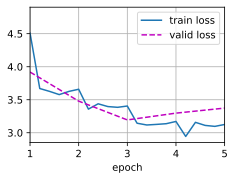

In [17]:
#@ TRAINING AND VALIDATING THE MODEL: 
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.001, 1e-4                              # Initializing the Parameters. 
lr_period, lr_decay, net = 10, 0.1, get_net(devices)                                          # Initializing the Neural Networks. 
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)          # Training the Model. 

Train loss 3.242
100.0 examples/secon [device(type='cuda', index=0)]


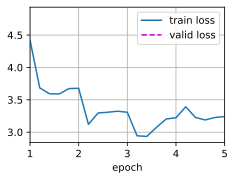

In [18]:
#@ CLASSIFYING THE TESTING SET: 
net = get_net(devices)                                                                        # Initializing the Neural Network. 
train(net, train_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)                # Training the Model.
preds = [] 
for data, label in test_iter: 
  output = nn.functional.softmax(net(data.to(devices[0])), dim=0)                             # Implementation of Softmax Function. 
  preds.extend(output.cpu().detach().numpy())                                                 # Initializing the Predictions. 
ids = sorted(os.listdir(os.path.join(data_dir, "train_valid_test", "test", "unknown")))
with open("result.csv", "w") as f: 
  f.write("id" + ",".join(train_valid_ds.classes) + "\n")
  for i, output in zip(ids, preds):
    f.write(i.split(".")[0] + "," + ",".join([str(num) for num in output]) + "\n")